# NiPy Backed fMRI Pipeline
## Max Kramer, 3/18/22
---

### Step 0: Import Required Packages

Make sure to build the conda environment using

`$ conda env create -f environment.yml`

and then activate it using

`$ conda activate NiPy_Pipeline`

before running this notebook

In [1]:
import os
import nibabel as nib
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from nilearn.plotting import view_img, plot_glass_brain, plot_anat, plot_epi, plot_stat_map, plot_img, plot_design_matrix, plot_contrast_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm import threshold_stats_img
from nltools.data import Brain_Data
from nilearn.image import concat_imgs, mean_img
from nipype.interfaces import afni
from bids import BIDSLayout, BIDSValidator

/home/mkramer/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)
/home/mkramer/anaconda3/lib/python3.7/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


### Step 1: Check Formatting of Data [PyBids]

This step does not currently work with my remote directory due to access privileges on MidwaySSD. Once they have been restored, I can use SAMBA to mount my project folder to my local machine and access the full 825gb dataset over the network. BIDSLayout() creates a structure of easily accessible data from the supplied directory with the following options for querying:

.path: The full path of the associated file

.filename: The associated file’s filename (without directory)

.dirname: The directory containing the file

.get_entities(): Returns information about entities associated with this BIDSFile (optionally including metadata)

.get_image(): Returns the file contents as a nibabel image (only works for image files)

.get_df(): Get file contents as a pandas DataFrame (only works for TSV files)

.get_metadata(): Returns a dictionary of all metadata found in associated JSON files

.get_associations(): Returns a list of all files associated with this one in some way

In [2]:
base_dir = 'fmri_data/ses-localizer1/sub-01'
anat_dir = base_dir + '/anat/'
epi_dir = base_dir + '/func/'
results_dir=base_dir+'/results/'

# layout = BIDSLayout(base_dir)
# layout

### Step 2: Read in fMRI Data [NiBabel]

In [3]:
# read in the anatomical 
anat_data = nib.load(anat_dir+'sub-01_ses-localizer1_acq-prescannormalized_T1w.nii.gz')
anat_data.shape # get dimensions of anatomical data

(208, 300, 320)

In [4]:
# read in functional data
num_runs = 2 # number of task runs
runs = [str(i+1).zfill(2) for i in range(num_runs)] # creates leading 0s
epi_data = [nib.load(epi_dir+'sub-01_ses-localizer1_task-6cat_run-'+run+'_bold.nii.gz') for run in runs]
epi_data[0].shape # get dimensions of a run of anatomical data

(96, 96, 60, 180)

In [5]:
mean_epi_img = mean_img(epi_data[0]) # average across EPI images for displaying activations
mean_epi_img.shape # get dimensionality

(96, 96, 60)

### Step 3: Pre-Analysis Visualization [NiLearn]

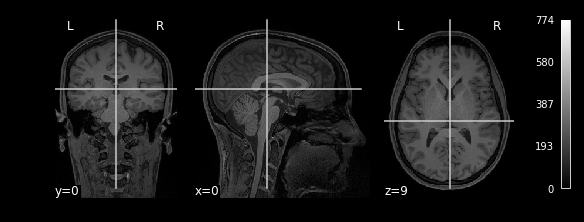

In [6]:
# plot the anatomical data
plot_anat(anat_data, colorbar=True, cbar_tick_format="%i");

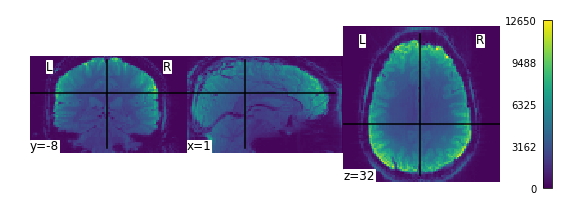

In [7]:
# plot a run of the functional data
plot_img(mean_epi_img, colorbar=True, cbar_tick_format="%i");

### Step 4: Preprocessing [niPype]

For now, this process involves the use of niPype to read in images that have been preprocessed by AFNI. In the future, this could be replaced with fmriprep to allow for completely python-native preprocessing.

In [8]:
# call AFNItoNIFTI() to transform preprocessed BRIK to .nii
a2n = afni.AFNItoNIFTI()
a2n.inputs.in_file = results_dir+'pb03.sub-01.r01.scale+orig.BRIK'
a2n.inputs.out_file = 'r1_epi_img.nii'
a2n.cmdline
res = a2n.run()
r1_epi_img = nib.load('r1_epi_img.nii')

220318-09:19:05,807 nipype.interface INFO:
	 stderr 2022-03-18T09:19:05.806894:++ 3dAFNItoNIFTI: AFNI version=AFNI_21.3.05 (Nov  7 2021) [64-bit]


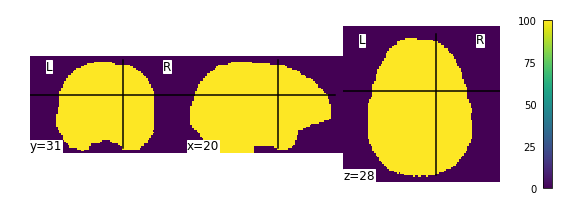

In [9]:
# check if data was loaded properly
plot_img(mean_img(r1_epi_img), colorbar=True, cbar_tick_format="%i");

### Step 5: Single Subject, Single Session Analysis [NiLearn]

In [10]:
# load in the event file for the run
events = pd.read_csv(results_dir+'sub-01_ses-localizer1_task-6cat_run-01_events.tsv', sep='\t')
events

,trial_type,onset,duration
0,bodyparts,15.0,15
1,words,34.5,15
2,scrambled,54.0,15
3,faces,73.5,15
4,scenes,93.0,15
5,objects,112.5,15
6,objects,142.5,15
7,scenes,162.0,15
8,faces,181.5,15
9,scrambled,201.0,15


In [11]:
# specify parameters for first level GLM
fmri_glm = FirstLevelModel(t_r=1.5,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=.01)

In [12]:
# run the GLM using the EPI data and the event file
fmri_glm = fmri_glm.fit(r1_epi_img, events)

/home/mkramer/anaconda3/lib/python3.7/site-packages/nilearn/glm/first_level/first_level.py:63: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


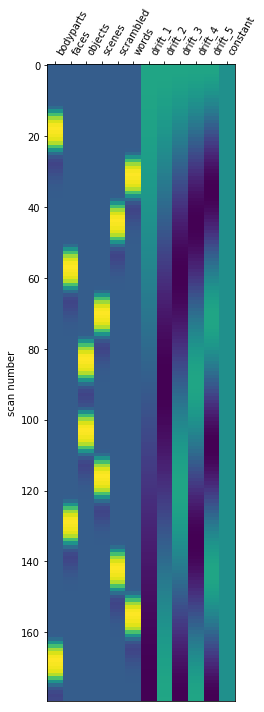

In [13]:
# examine the design matrix
design_matrix = fmri_glm.design_matrices_[0]
plot_design_matrix(design_matrix);

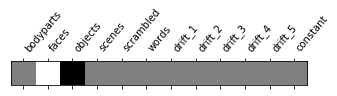

In [14]:
# Set up a Linear Contrast
conditions = {
    'face': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'nonface':   array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
}

FFA_contrast = conditions['face'] - conditions['nonface'] # set up GLT
plot_contrast_matrix(FFA_contrast, design_matrix=design_matrix); # visualize contrast matrix

In [15]:
# create a map of thresholded z-scores for plotting
z_map = fmri_glm.compute_contrast(FFA_contrast,
                                  output_type='z_score')

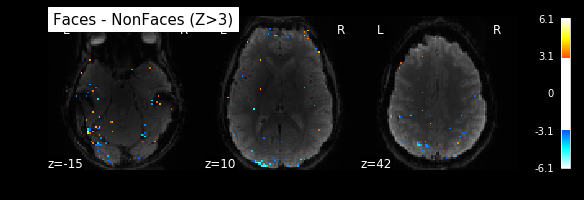

In [16]:
plot_stat_map(z_map, bg_img=mean_epi_img, threshold=3.0,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Faces - NonFaces (Z>3)');

Bonferroni-corrected, p<0.05 threshold: 5.142


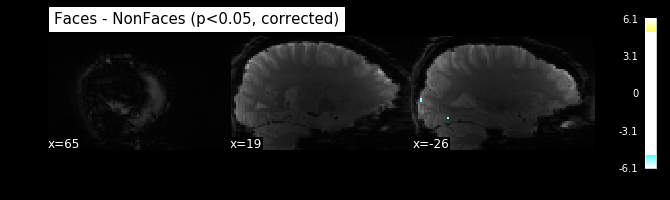

In [17]:
_, threshold = threshold_stats_img(
    z_map, alpha=.05, height_control='bonferroni')
print('Bonferroni-corrected, p<0.05 threshold: %.3f' % threshold)

plot_stat_map(z_map, bg_img=mean_epi_img, threshold=threshold,
              display_mode='x', cut_coords=3, black_bg=True,
              title='Faces - NonFaces (p<0.05, corrected)');

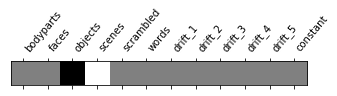

In [18]:
# Now do the same for PPA
conditions = {
    'face': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'nonface':   array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
}

PPA_contrast = conditions['face'] - conditions['nonface'] # set up GLT
plot_contrast_matrix(PPA_contrast, design_matrix=design_matrix); # visualize contrast matrix

Bonferroni-corrected, p<0.05 threshold: 5.142


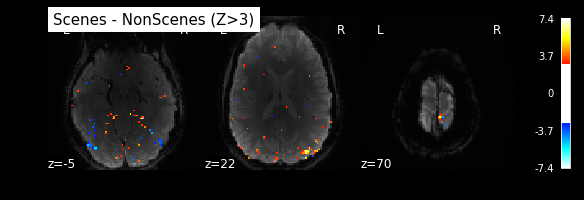

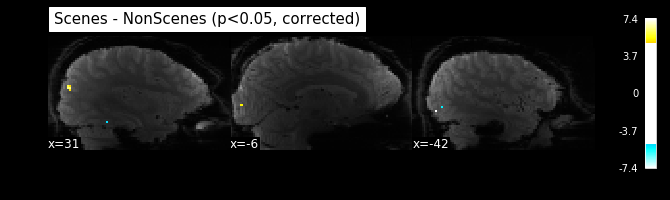

In [19]:
z_map = fmri_glm.compute_contrast(PPA_contrast,
                                  output_type='z_score')

plot_stat_map(z_map, bg_img=mean_epi_img, threshold=3.0,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Scenes - NonScenes (Z>3)');

_, threshold = threshold_stats_img(
    z_map, alpha=.05, height_control='bonferroni')
print('Bonferroni-corrected, p<0.05 threshold: %.3f' % threshold)

plot_stat_map(z_map, bg_img=mean_epi_img, threshold=threshold,
              display_mode='x', cut_coords=3, black_bg=True,
              title='Scenes - NonScenes (p<0.05, corrected)');